## 导入基础库

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score

In [3]:
# 在导入基础库部分后添加这段代码
import matplotlib.pyplot as plt
import matplotlib as mpl

# 设置全局字体为 Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['mathtext.fontset'] = 'stix'  # 保证数学文本也使用相似的字体

## stacking

In [4]:
data = pd.read_csv('/Users/lixian/workplace/transaction_scam_detection/data/prepared_scam_detection_dataset.csv')
data.drop('wallet_id', axis=1, inplace=True)
y = data['is_scam']
X = data.drop('is_scam',axis=1)
print("X.shape", X.shape, "y.shape", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=123)
print("X_train.shape", X_train.shape, "y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape, "y_test.shape", y_test.shape)


X.shape (10000, 36) y.shape (10000,)
X_train.shape (8000, 36) y_train.shape (8000,)
X_test.shape (2000, 36) y_test.shape (2000,)


In [5]:
import pickle
import torch
import torch.nn as nn

# Define the MLP class first
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# 加载随机森林模型
with open('/Users/lixian/workplace/dl_predictionv1/model/model_rfc_best.pkl', 'rb') as f:
    model_rfc_best = pickle.load(f)
# 加载 LightGBM 模型
with open('/Users/lixian/workplace/dl_predictionv1/model/model_lgb_best.pkl', 'rb') as f:
    model_lgb_best = pickle.load(f)
    
# 加载 MLP 模型
model_mlp_best_real = torch.load('/Users/lixian/workplace/dl_predictionv1/model/model_mlp_best_real.pkl')

/var/folders/6_/bl3k57hx2nv_hyp55sxq7v_80000gn/T/ipykernel_87896/1274028811.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_mlp_best_real = torch.load('/Users/lix

In [6]:
import lightgbm as lgb


def lgb_predict(X_train, y_train, X_test, y_test=None): 
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)
    train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
    valid_matrix = lgb.Dataset(X_val, label=y_val)
    model = lgb.train(model_lgb_best.params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix])
    """计算在验证集上的得分"""
    val_pred = model.predict(X_val)
    fpr, tpr, threshold = metrics.roc_curve(y_val, val_pred)
    roc_auc = metrics.auc(fpr, tpr)
    print('调参后lightgbm单模型在验证集上的AUC：{}'.format(roc_auc))
    
    """对测试集进行预测"""
    test_pred = model.predict(X_test)   
     
    return test_pred


In [7]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn import metrics
def rfc_predict(X_train, y_train, X_test, y_test=None):
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123)
    model = RFC(** model_rfc_best.get_params())
    model = RFC().fit(X_train_split,y_train_split)   
    """计算在验证集上的得分"""
    val_pred = model.predict(X_val)
    fpr, tpr, threshold = metrics.roc_curve(y_val, val_pred)
    roc_auc = metrics.auc(fpr, tpr)
    print('调参后RandomForest单模型在验证集上的AUC：{}'.format(roc_auc))
    
    """对测试集进行预测"""
    test_pred = model.predict(X_test) 
    return test_pred


In [8]:
from heamy.dataset import Dataset
from heamy.estimator import Classifier

model_dataset = Dataset(X_train=X_train, y_train=y_train, X_test=X_test) #创建一个数据集对象 model_dataset
#使用 heamy 中的 Classifier 类来包装 XGBoost 和 LightGBM 模型，指定数据集、模型和其他相关参数,必须有回调
model_lgb = Classifier(dataset=model_dataset, estimator=lgb_predict, name='lgb', use_cache=False) #禁用了缓存功能（即每次都会重新训练模型）
model_rfc = Classifier(dataset=model_dataset, estimator=rfc_predict, name='rfc', use_cache=False) 



In [9]:
from heamy.pipeline import ModelsPipeline

pipeline = ModelsPipeline(model_lgb, model_rfc)
pipeline


In [10]:
# 构建第一层新特征，其中k默认是5，表示5折交叉验证，full_test=True，对全部训练集进行训练得到基学习器，然后用基学习器对测试集预测得到新特征
stack_ds = pipeline.stack(k=5, seed=111, full_test=True)


/Users/lixian/miniconda3/envs/tf/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/lixian/miniconda3/envs/tf/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


调参后lightgbm单模型在验证集上的AUC：1.0
调参后lightgbm单模型在验证集上的AUC：1.0
调参后lightgbm单模型在验证集上的AUC：1.0


/Users/lixian/miniconda3/envs/tf/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/lixian/miniconda3/envs/tf/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


调参后lightgbm单模型在验证集上的AUC：1.0
调参后lightgbm单模型在验证集上的AUC：1.0


/Users/lixian/miniconda3/envs/tf/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/Users/lixian/miniconda3/envs/tf/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


调参后lightgbm单模型在验证集上的AUC：1.0
调参后RandomForest单模型在验证集上的AUC：1.0
调参后RandomForest单模型在验证集上的AUC：1.0
调参后RandomForest单模型在验证集上的AUC：1.0
调参后RandomForest单模型在验证集上的AUC：1.0
调参后RandomForest单模型在验证集上的AUC：1.0
调参后RandomForest单模型在验证集上的AUC：1.0


In [11]:
from sklearn.linear_model import LogisticRegression
# 第二层使用逻辑回归进行stack
LogisticRegression(solver='lbfgs')
stacker = Classifier(dataset=stack_ds, estimator=LogisticRegression, parameters={'solver': 'lbfgs'})

# 测试集的预测结果
test_pred = stacker.predict()
print(test_pred)
print(type(test_pred))
# 计算测试集 AUC
auc = roc_auc_score(y_test, test_pred)
print(f'多模型在测试集AUC: {auc:.4f}')
    

[8.14572741e-04 8.14572741e-04 8.14572741e-04 ... 9.99256929e-01
 8.14572741e-04 8.14572741e-04]
<class 'numpy.ndarray'>
多模型在测试集AUC: 1.0000


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

test_pred_labels = (test_pred >= 0.5).astype(int)
# Transform y_test to have values 0 and 1 instead of -1 and 1
y_test_transformed = (y_test > 0).astype(int)
accuracy_test = accuracy_score(y_test_transformed, test_pred_labels)
precision_test = precision_score(y_test_transformed, test_pred_labels)
recall_test = recall_score(y_test_transformed, test_pred_labels)
f1_test = f1_score(y_test_transformed, test_pred_labels)

print(f"测试集准确率: {accuracy_test:.4f}")
print(f"测试集精确率: {precision_test:.4f}")
print(f"测试集召回率: {recall_test:.4f}")
print(f"测试集F1分数: {f1_test:.4f}")

测试集准确率: 1.0000
测试集精确率: 1.0000
测试集召回率: 1.0000
测试集F1分数: 1.0000


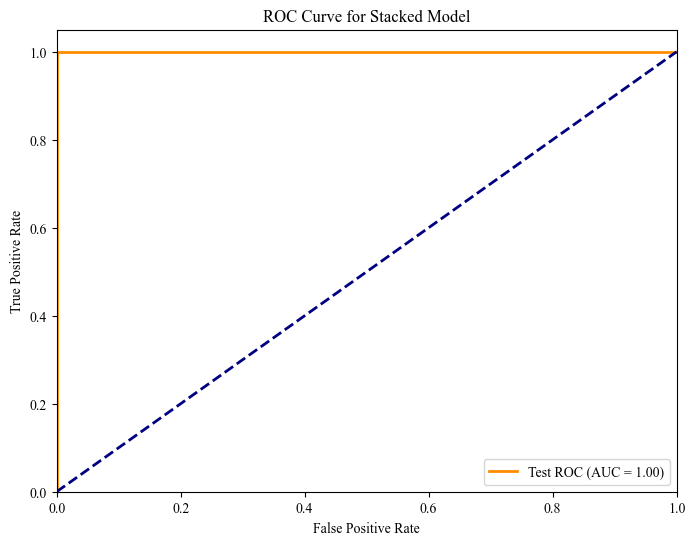

In [13]:
# 绘制测试集的 ROC 曲线
from sklearn.metrics import roc_curve
test_fpr, test_tpr, _ = roc_curve(y_test, test_pred)
test_auc = roc_auc_score(y_test, test_pred)

plt.figure(figsize=(8, 6))
plt.plot(test_fpr, test_tpr, color='darkorange', lw=2, label=f'Test ROC (AUC = {test_auc:.2f})')  # 橙色代表测试集
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 随机猜测的对角线

# 调整图像显示范围
plt.xlim([0.0, 1.0])  # 设置x轴范围
plt.ylim([0.0, 1.05])  # 设置y轴范围

# 设置图表标签
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Stacked Model')  

# 添加图例
plt.legend(loc="lower right")

# 显示图像
plt.show()

## shap分析

In [14]:
# import numpy as np
# import shap

# # 假设 X_train 和 model_lgb_best 已经定义
# # 使用 X_train 的一部分作为背景数据（这里选择前100个样本）
# background = X_train[:100]

# # 初始化 SHAP TreeExplainer
# explainer = shap.TreeExplainer(model_lgb_best,
#                                data=background,
#                                model_output="probability",
#                                feature_perturbation="interventional")

# # 计算 SHAP 值
# shap_vals = explainer.shap_values(X_train)
# print("原始 SHAP 值 shape:", shap_vals.shape)

# # 如果返回的 shape 的第一个维度等于 X_train 的样本数，则不需要转置，否则转置
# if shap_vals.shape[0] == X_train.shape[0]:
#     shap_vals_correct = shap_vals  # 已经是 (n_samples, n_features)
# else:
#     shap_vals_correct = shap_vals.T  # 转置为 (n_samples, n_features)
# print("调整后的 SHAP 值 shape:", shap_vals_correct.shape)

# # 根据二分类的加性性质，负类的 SHAP 值可以取正类 SHAP 值的相反数
# shap_vals_neg = -shap_vals_correct

# # 堆叠得到 (n_samples, n_features, 2)，其中最后一维：[负类, 正类]
# shap_values_stacked = np.stack([shap_vals_neg, shap_vals_correct], axis=-1)
# print("堆叠后的 SHAP 值 shape:", shap_values_stacked.shape)


In [15]:
import shap
import pickle
from sklearn.linear_model import LogisticRegression

# 1. 获取元模型系数
stacked_X_train = stack_ds.X_train
stacked_y_train = stack_ds.y_train
meta_model = LogisticRegression(solver='lbfgs')
meta_model.fit(stacked_X_train, stacked_y_train)
coefficients = meta_model.coef_[0]
print("逻辑回归系数:", coefficients)

# 2. 计算基模型 SHAP 值

# 使用K-means生成代表性背景样本（100个）
X_sample = shap.kmeans(X_train, 100)  


shap_values_lgb_nc = shap.TreeExplainer(model_lgb_best,data=X_train[:100], model_output="probability",feature_perturbation="interventional").shap_values(X_train)

shap_values_lgb = np.stack([-shap_values_lgb_nc, shap_values_lgb_nc], axis=-1)

# Use interventional feature perturbation for RFC
explainer_rfc = shap.TreeExplainer(
    model_rfc_best,
    data=X_train[:100],
    feature_perturbation="interventional"
)
shap_values_rfc_list = explainer_rfc.shap_values(X_train, check_additivity=False)

# Convert RFC SHAP values to the same format as LGB
# For binary classification, RFC returns a list with values for each class
shap_values_rfc = np.stack(shap_values_rfc_list, axis=-1)


print("SHAP values shapes:")

print("LGB:", shap_values_lgb.shape)
print("RFC:", shap_values_rfc.shape)

# 确保两个数组形状一致
if shap_values_lgb.shape != shap_values_rfc.shape:
    # 正确的转置：将 (36,2,8000) 转换为 (8000,36,2)
    shap_values_rfc = np.transpose(shap_values_rfc, (2, 0, 1))
    print("RFC after transpose:", shap_values_rfc.shape)

# 3. 合并 SHAP 值
shap_values_final = ( coefficients[0] * shap_values_lgb + 
                     coefficients[1] * shap_values_rfc)


逻辑回归系数: [2.26933242 6.18490176]


100%|===================| 15928/16000 [02:10<00:00]        

SHAP values shapes:
LGB: (8000, 36, 2)
RFC: (36, 2, 8000)
RFC after transpose: (8000, 36, 2)


In [16]:
print(shap_values_final.shape)

(8000, 36, 2)


### 蜂群图

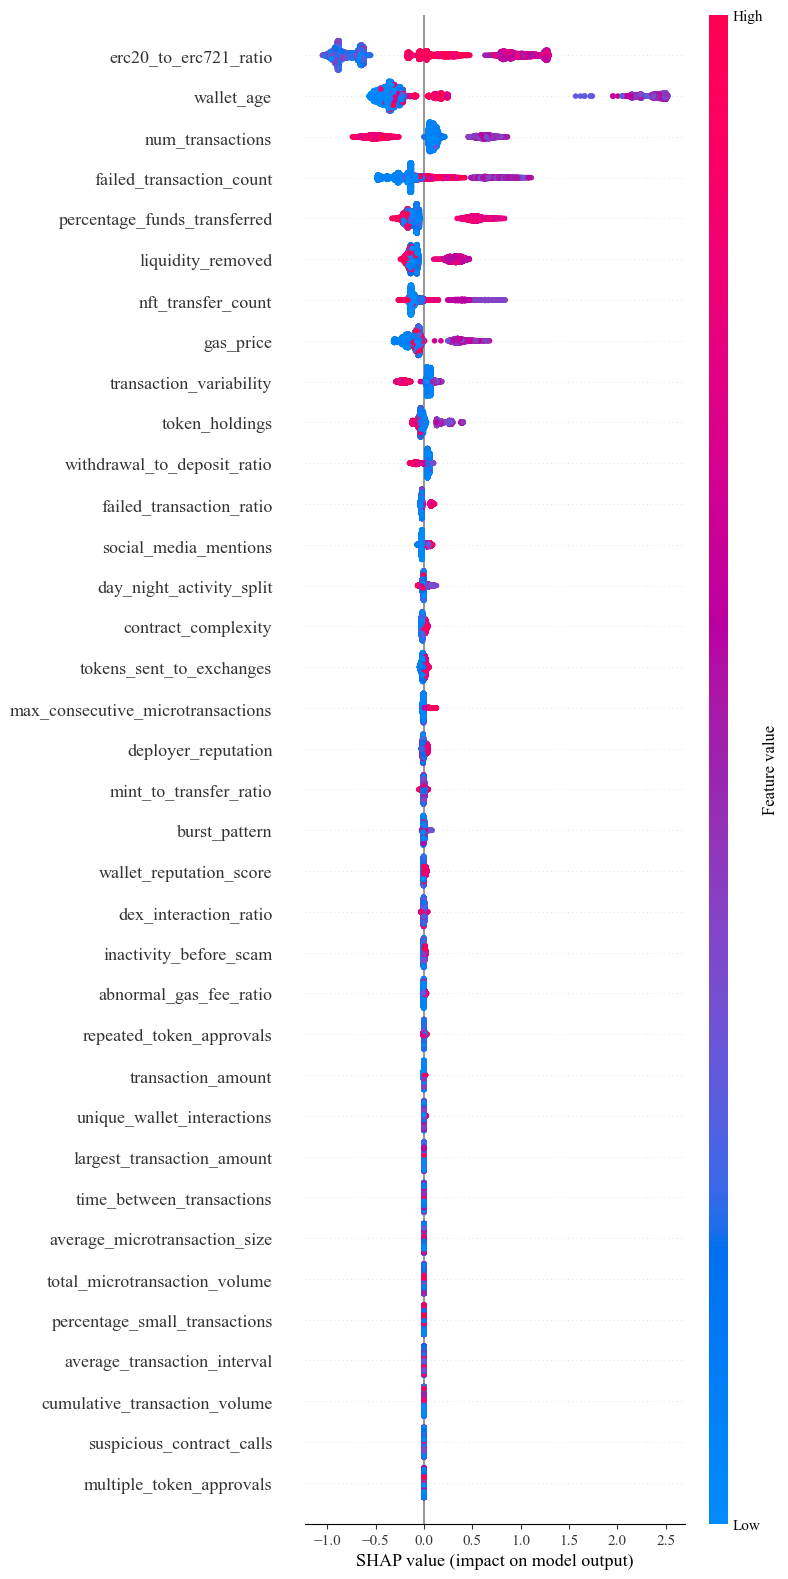

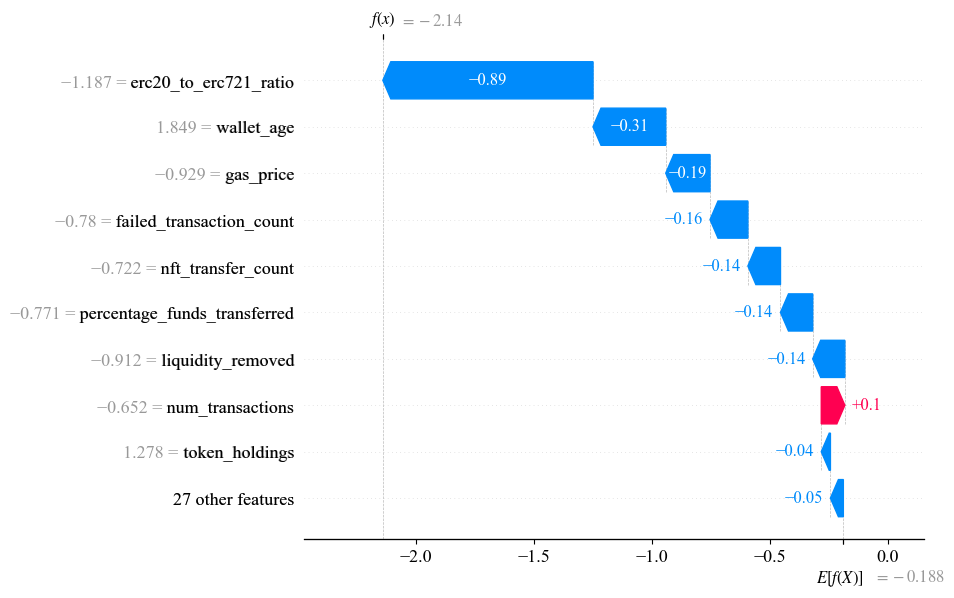

In [17]:
# 假设 shap_values_final 的形状为 (31308, 37, 2)
# 选择正类（第二个类别）的 SHAP 值，得到 (31308, 37)
shap_values_pos = shap_values_final[:, :, 1]

# 1. 绘制 summary plot
shap.summary_plot(shap_values_pos, X_train, feature_names=X_train.columns,max_display = 37)

# 2. 绘制单个样本的 SHAP 瀑布图
# 对于单个样本（例如第一行），选择正类的 SHAP 值，其形状为 (37,)
# 同时 expected_value 应该为正类的基准输出值
expected_value = ( coefficients[0] * shap_values_lgb[:, :, 1] + 
                  coefficients[1] * shap_values_rfc[:, :, 1])

shap.waterfall_plot(shap.Explanation(values=shap_values_final[1, :, 1],
                                     base_values=expected_value[1, 1],
                                     data=X_train.iloc[1],
                                     feature_names=X_train.columns.tolist()))


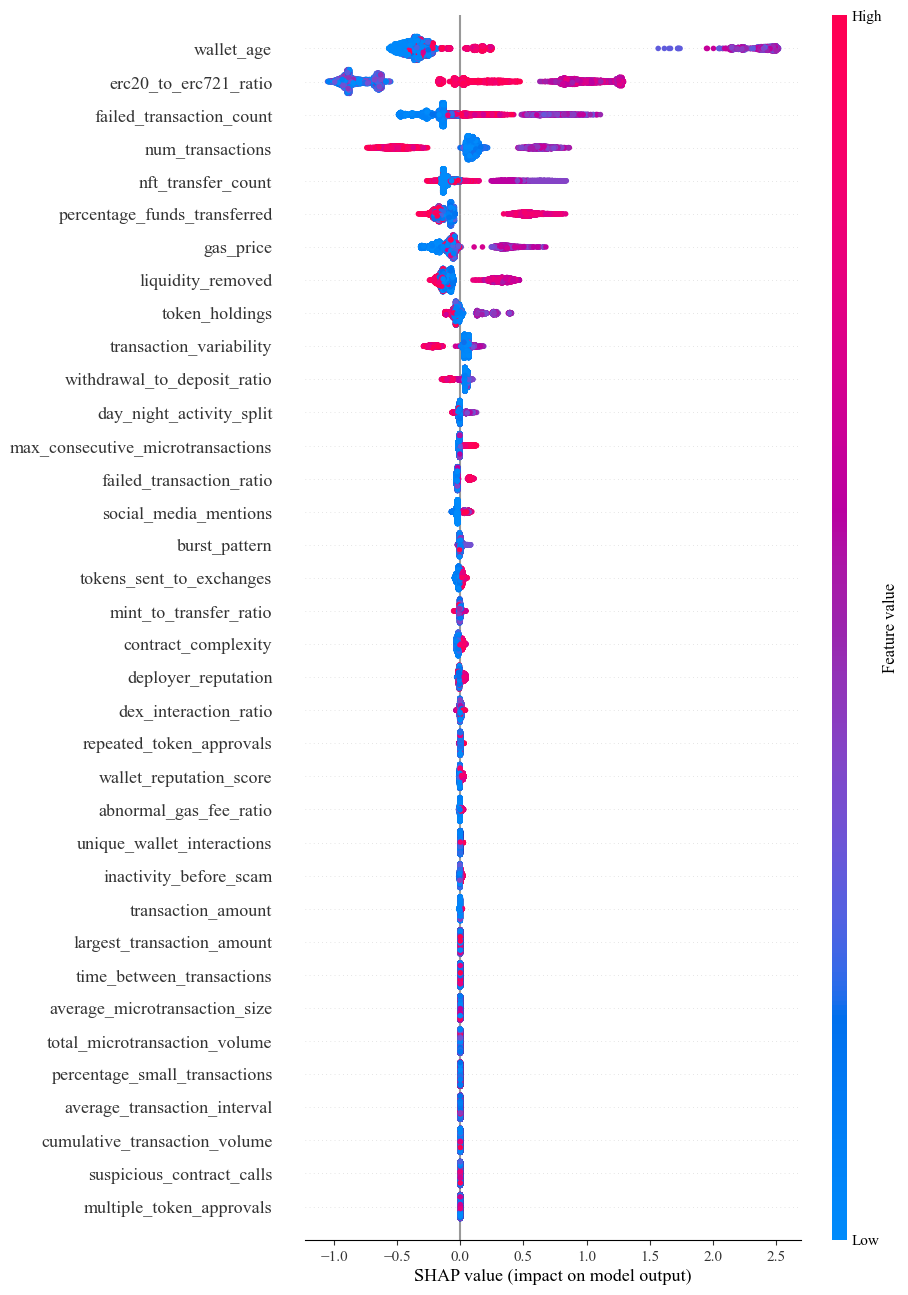

In [18]:
# 在调用 SHAP 可视化函数前设置 matplotlib 参数
import matplotlib as mpl

# 设置全局字体为 Times New Roman
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['mathtext.fontset'] = 'stix'

#  shap_values_pos 从NumPy 数组转换为 shap.Explanation 对象
shap_values_pos_shap = shap.Explanation(values=shap_values_pos, data=X_train, feature_names=X_train.columns)

# 1. 使用 beeswarm 绘制图表
shap.plots.beeswarm(shap_values_pos_shap, max_display=37, order=shap_values_pos_shap.abs.max(0))

### 依赖图

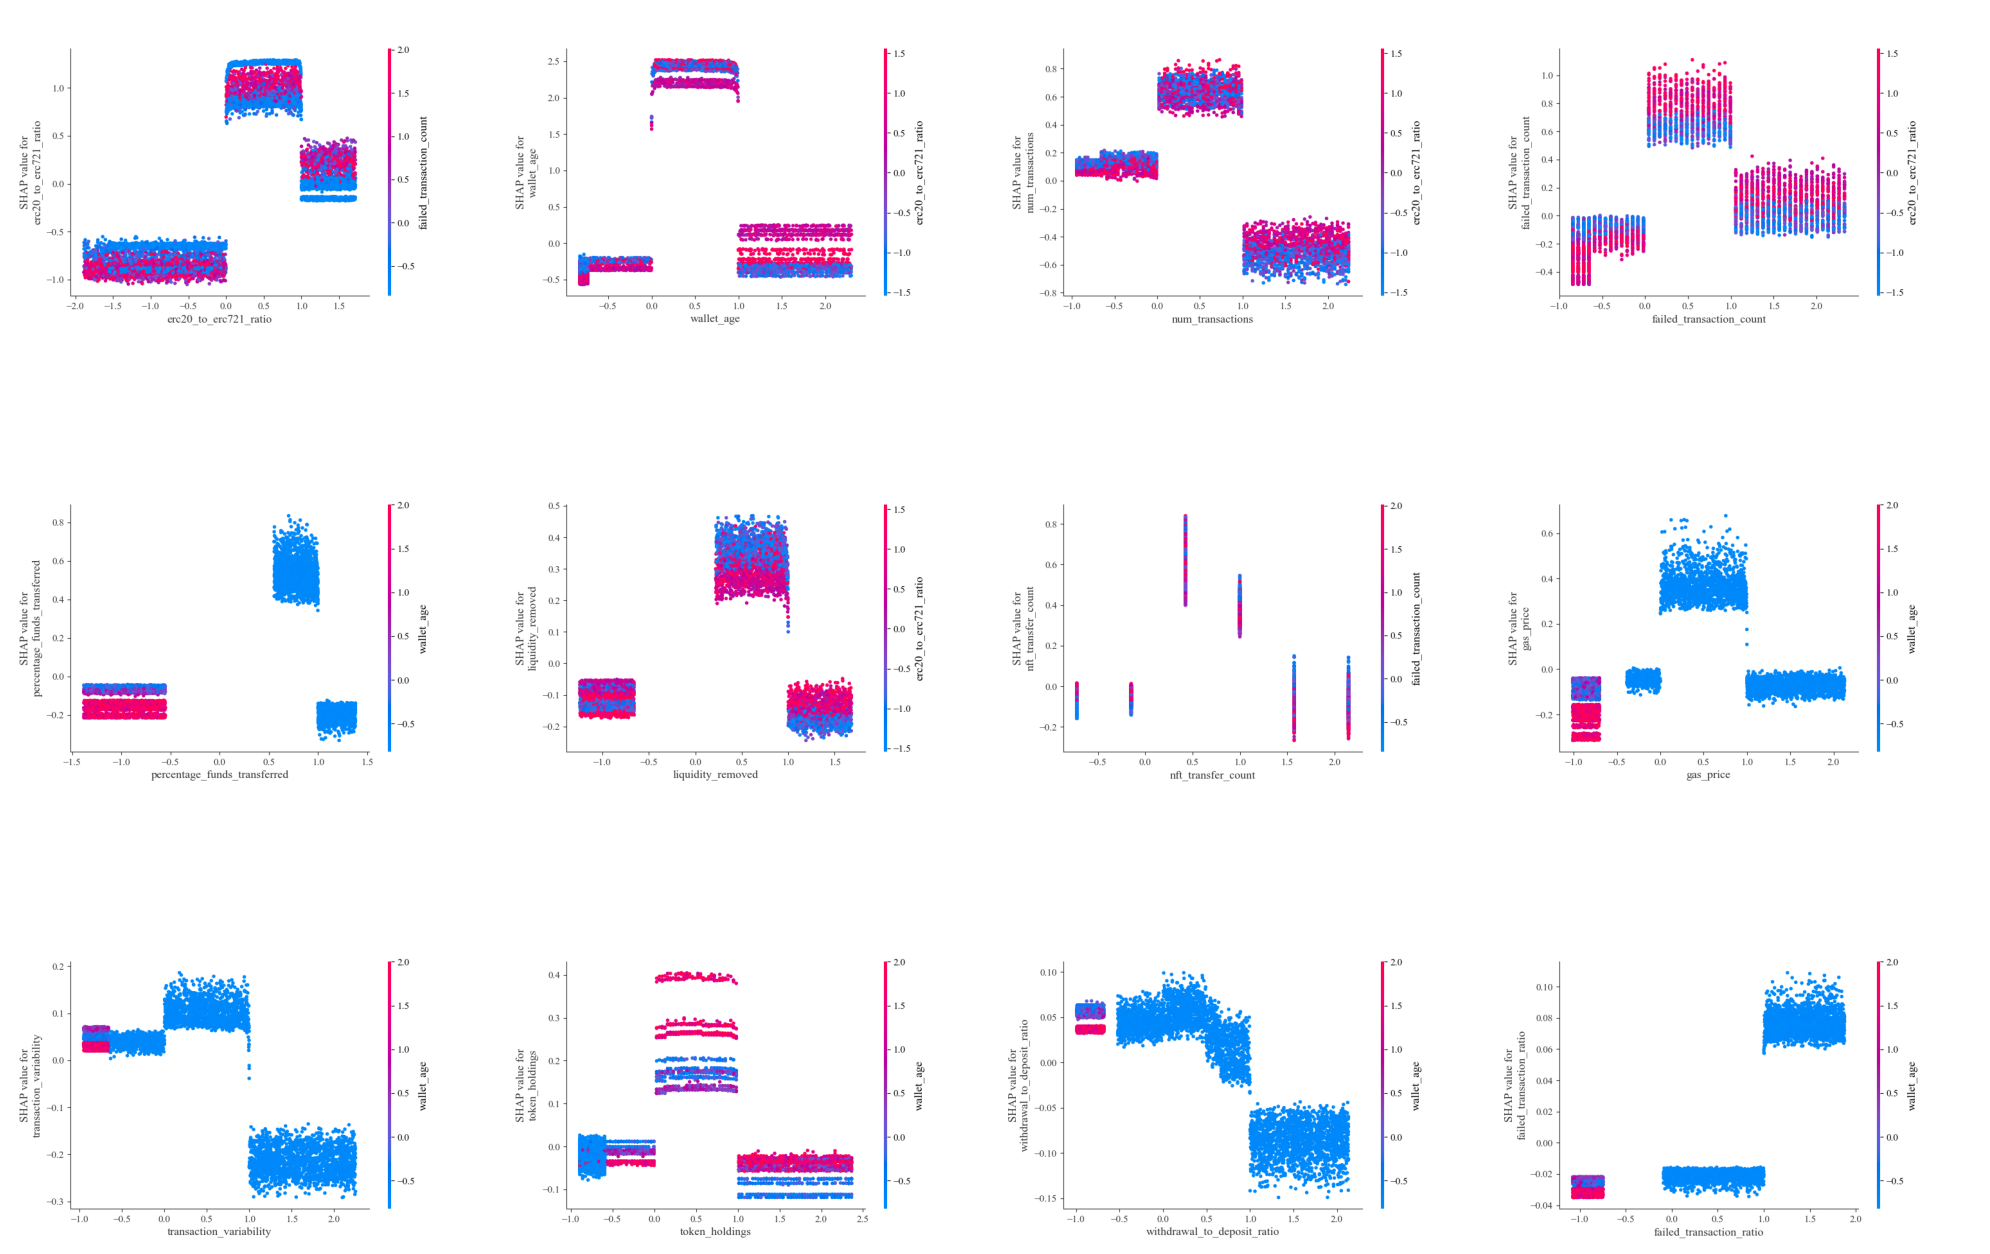

In [19]:
import shap
import matplotlib.pyplot as plt
import io
from PIL import Image

# 选择前12个特征
selected_features = [
    "erc20_to_erc721_ratio",  
    "wallet_age",
    "num_transactions",
    "failed_transaction_count",
    "percentage_funds_transferred",
    "liquidity_removed",
    "nft_transfer_count",
    "gas_price",
    "transaction_variability",
    "token_holdings",
    "withdrawal_to_deposit_ratio",
    "failed_transaction_ratio"
]

# 创建3行4列的子图
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for i, feature in enumerate(selected_features):
    # 使用内存缓冲区保存依赖图
    buf = io.BytesIO()
    # 设置 show=False 防止立即显示
    shap.dependence_plot(feature, shap_values_pos, X_train, feature_names=X_train.columns, show=False)
    plt.savefig(buf, format='png')
    plt.close()  # 关闭依赖图生成的图形窗口
    buf.seek(0)
    im = Image.open(buf)
    
    # 将图片显示在对应的子图上
    axes[i].imshow(im)
    axes[i].axis('off')  # 关闭坐标轴

plt.tight_layout()
plt.show()

In [1]:

# 选择前12个特征
selected_features = [
    "erc20_to_erc721_ratio",  
    "wallet_age",
    "num_transactions",
    "failed_transaction_count",
    "percentage_funds_transferred",
    "liquidity_removed",
    "nft_transfer_count",
    "gas_price",
    "transaction_variability",
    "token_holdings",
    "withdrawal_to_deposit_ratio",
    "failed_transaction_ratio"
]
# 为每个特征绘制依赖图
for feature in selected_features:
    shap.dependence_plot(feature, shap_values_pos, X_train, feature_names=X_train.columns) 

NameError: name 'shap' is not defined

### 散点图

In [19]:
import shap

# 选择前12个特征
selected_features = ['liquid', 'finance', 'land_asset', 'consumption', 'housing', 'industry_structure', 'entrep', 'marriage', 'cpc', 'h_loan','house','old']
# 为每个特征绘制散点图
for feature in selected_features:
    shap.plots.scatter(feature, shap_values_pos_shap, X_train)

AssertionError: The shap_values parameter must be a shap.Explanation object!

## 使用blending融合

In [21]:
from sklearn.linear_model import LogisticRegression
# 构建第一层新特征，将训练集切分成8:2，其中80%用于训练基学习器，20%用于构建新特征
blend_ds = pipeline.blend(proportion=0.2,seed=111)
# 第二层使用逻辑回归进行blend
blender = Classifier(dataset=blend_ds, estimator=LogisticRegression, parameters={'solver': 'lbfgs'})
# 测试集的预测结果
test_pred = blender.predict()
test_pred
# 计算测试集 AUC
auc = roc_auc_score(y_test, test_pred)
print(f'多模型在测试集AUC: {auc:.4f}')

调参后MLP单模型在验证集AUC: 0.9728


/Users/lixian/miniconda3/envs/tf/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


调参后lightgbm单模型在验证集上的AUC：0.9666734198538284
调参后RandomForest单模型在验证集上的AUC：0.9396241954953638
多模型在测试集AUC: 0.9765


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

test_pred_labels = (test_pred >= 0.5).astype(int)
accuracy_test = accuracy_score(y_test, test_pred_labels)
precision_test = precision_score(y_test, test_pred_labels)
recall_test = recall_score(y_test, test_pred_labels)
f1_test = f1_score(y_test, test_pred_labels)

print(f"测试集准确率: {accuracy_test:.4f}")
print(f"测试集精确率: {precision_test:.4f}")
print(f"测试集召回率: {recall_test:.4f}")
print(f"测试集F1分数: {f1_test:.4f}")

测试集准确率: 0.9398
测试集精确率: 0.9797
测试集召回率: 0.8998
测试集F1分数: 0.9381


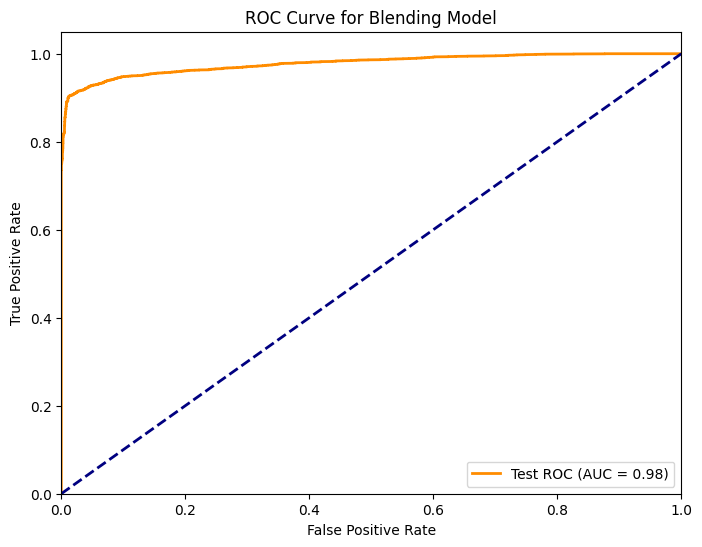

In [86]:
# 绘制测试集的 ROC 曲线
from sklearn.metrics import roc_curve
test_fpr, test_tpr, _ = roc_curve(y_test, test_pred)
test_auc = roc_auc_score(y_test, test_pred)

plt.figure(figsize=(8, 6))
plt.plot(test_fpr, test_tpr, color='darkorange', lw=2, label=f'Test ROC (AUC = {test_auc:.2f})')  # 橙色代表测试集
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 随机猜测的对角线

# 调整图像显示范围
plt.xlim([0.0, 1.0])  # 设置x轴范围
plt.ylim([0.0, 1.05])  # 设置y轴范围

# 设置图表标签
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Blending Model')  

# 添加图例
plt.legend(loc="lower right")

# 显示图像
plt.show()

## 保存模型

In [40]:
# 保存模型
import pickle
pickle.dump(stacker, open('/Users/lixian/workplace/transaction_scam_detection/model/stacker.pkl', 'wb'))


In [20]:
!pip install gunicorn waitress requests flask 


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
